## Indetificar a los operadores menos eficientes

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# cargar los datasets
calls_info_df_c = pd.read_csv('../datasets/clean/calls_info_df_clean.csv')
clients_df_c = pd.read_csv('../datasets/clean/clients_df_clean.csv')

1. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas).

2. Un tiempo de espera prolongado para las llamadas entrantes.

3. Un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

In [3]:
# vamos a dividir en dos data frames llamadas entrantes y salientes y excluir a los operadores no identificados
filtro_operator_id = calls_info_df_c[calls_info_df_c['operator_id'] != 'No indentificado']

# Verificar los valores únicos de 'operator_id' después del filtro
print(filtro_operator_id['operator_id'].unique())

['880022' '880020' '881278' ... '952916' '959118' '957922']


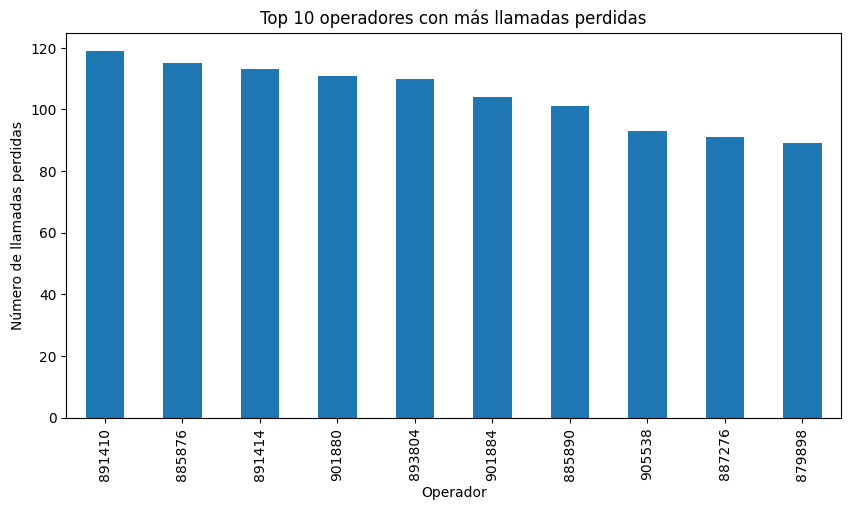

In [4]:
# Agrupar por operador y contar llamadas perdidas
missed_calls_by_operator_ = filtro_operator_id[filtro_operator_id['is_missed_call']].groupby('operator_id').size()

# Gráfico de barras
missed_calls_by_operator_.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 operadores con más llamadas perdidas')
plt.xlabel('Operador')
plt.ylabel('Número de llamadas perdidas')
plt.show()

In [5]:
# filtramos por dirección de la llamada
calls_in = filtro_operator_id[filtro_operator_id['direction'] == 'in']
calls_out = filtro_operator_id[filtro_operator_id['direction'] == 'out']

In [6]:
metrics_in = calls_in.groupby('operator_id').agg(
    total_llamadas=('calls_count', 'sum'),
    llamadas_perdidas=('is_missed_call', 'sum'),
    duracion_promedio=('call_duration', 'mean'),
    tiempo_espera_promedio=('total_call_duration', 'mean')
)

# Paso 4: Calcular métricas por operador para llamadas salientes
metrics_out = calls_out.groupby('operator_id').agg(
    total_llamadas=('calls_count', 'sum'),
    llamadas_perdidas=('is_missed_call', 'sum'),
    duracion_promedio=('call_duration', 'mean'),
    tiempo_espera_promedio=('total_call_duration', 'mean')
)

# Mostrar resultados
print("Métricas para llamadas entrantes:")
print(metrics_in.head())
print()
print(metrics_in.count())

print("\nMétricas para llamadas salientes:")
print(metrics_out.head())
print()
print(metrics_out.count())

Métricas para llamadas entrantes:
             total_llamadas  llamadas_perdidas  duracion_promedio  \
operator_id                                                         
879896                   58                  0         267.428571   
879898                  104                  0         111.456140   
880020                    7                  0          42.714286   
880022                    8                  0          64.000000   
880026                   24                  0          88.166667   

             tiempo_espera_promedio  
operator_id                          
879896                   294.761905  
879898                   140.929825  
880020                    50.428571  
880022                    78.000000  
880026                    96.111111  

total_llamadas            754
llamadas_perdidas         754
duracion_promedio         754
tiempo_espera_promedio    754
dtype: int64

Métricas para llamadas salientes:
             total_llamadas  llamadas_perdidas 

In [7]:
# calcular las medias para determinar los umbrales
mean_call_missed_in = (metrics_in['llamadas_perdidas'].sum() / metrics_in['total_llamadas'].sum()) * 100
mean_wait_in = (metrics_in['tiempo_espera_promedio'] - metrics_in['duracion_promedio']).mean()

mean_call_missed_out = metrics_out['llamadas_perdidas'].mean()

In [8]:
print(mean_call_missed_in)
print(mean_wait_in)
print(mean_call_missed_out)

0.7302616148909405
57.61280684438693
15.22108843537415


1. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas).

In [9]:
# Definir umbrales
threshold_missed = mean_call_missed_in  #% de llamadas perdidas
threshold_wait = mean_wait_in     # segundos de tiempo de espera promedio
threshold_outgoing = mean_call_missed_out # llamadas salientes

# Identificar operadores ineficaces en llamadas entrantes
metrics_in['ineffective_in'] = (
    (metrics_in['llamadas_perdidas'] / metrics_in['total_llamadas'] > threshold_missed) |  # Alto porcentaje de llamadas perdidas
    (metrics_in['tiempo_espera_promedio'] - metrics_in['duracion_promedio'] > threshold_wait)  # Tiempo de espera prolongado
)

# Identificar operadores ineficaces en llamadas salientes
metrics_out['ineffective_out'] = (
    metrics_out['total_llamadas'] < threshold_outgoing  # Pocas llamadas salientes
)  # Duración de llamada muy alta


# Filtrar operadores ineficaces
ineffective_operators_in = metrics_in[metrics_in['ineffective_in']]
ineffective_operators_out = metrics_out[metrics_out['ineffective_out']]

# Mostrar resultados
print("Operadores ineficaces en llamadas entrantes:")
print(ineffective_operators_in)

print("\nOperadores ineficaces en llamadas salientes:")
print(ineffective_operators_out)

Operadores ineficaces en llamadas entrantes:
             total_llamadas  llamadas_perdidas  duracion_promedio  \
operator_id                                                         
882684                  613                  4        2614.060000   
882686                  766                  5        2117.205882   
882688                   15                  0         741.500000   
882690                  171                  2         665.363636   
884408                   35                  3         123.428571   
...                     ...                ...                ...   
969294                   84                  0        1869.750000   
970244                    2                  0         141.000000   
970254                    3                  0         117.000000   
971102                   76                  0        2653.000000   
973286                    2                  0          17.000000   

             tiempo_espera_promedio  ineffective_in  
ope

### Proponer una hipótesis

Eficacia de los operadores:

Hipótesis:

H0: No hay diferencia en el número de llamadas salientes entre operadores ineficaces y eficaces.   
H1: Los operadores ineficaces realizan significativamente menos llamadas salientes.

In [13]:
# Supongamos que ya tienes metrics_out con la columna 'ineffective_out'
# Filtrar operadores ineficaces y eficaces
llamadas_ineficaces = metrics_out[metrics_out['ineffective_out']]['total_llamadas']
llamadas_eficaces = metrics_out[~metrics_out['ineffective_out']]['total_llamadas']


u_stat, p_value = mannwhitneyu(llamadas_ineficaces, llamadas_eficaces)
print("\nResultado de la prueba U de Mann-Whitney:")
print(f"Estadístico U: {u_stat:.2f}, Valor p: {p_value:.4f}")

# Interpretación
if p_value < 0.05:
    print("\nRechazamos la hipótesis nula: Hay una diferencia significativa en el número de llamadas salientes.")
else:
    print("\nNo rechazamos la hipótesis nula: No hay una diferencia significativa en el número de llamadas salientes.")


Resultado de la prueba U de Mann-Whitney:
Estadístico U: 0.00, Valor p: 0.0000

Rechazamos la hipótesis nula: Hay una diferencia significativa en el número de llamadas salientes.


/var/folders/2k/b1dxbcm15wl1lwf54_m3c9lm0000gn/T/ipykernel_41191/1691240719.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=metrics_out['ineffective_out'], y=metrics_out['total_llamadas'], palette='Set2')


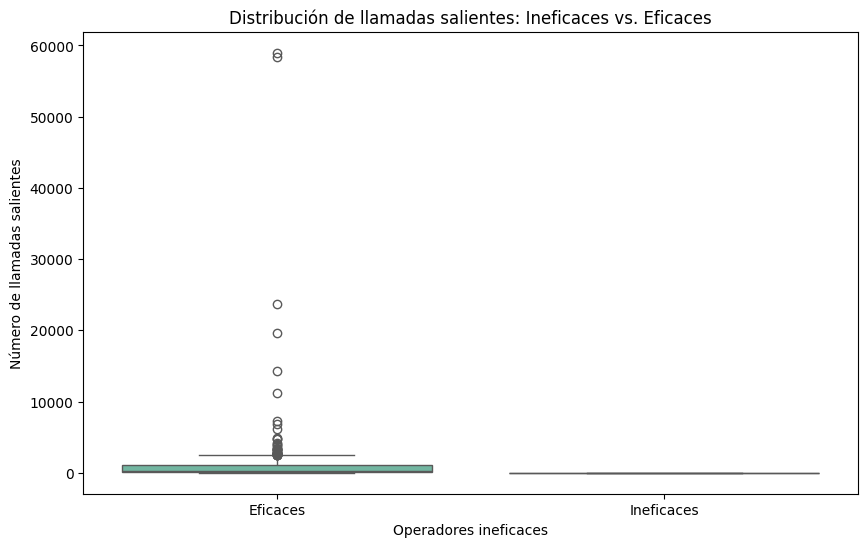

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=metrics_out['ineffective_out'], y=metrics_out['total_llamadas'], palette='Set2')
plt.title('Distribución de llamadas salientes: Ineficaces vs. Eficaces')
plt.xlabel('Operadores ineficaces')
plt.ylabel('Número de llamadas salientes')
plt.xticks([0, 1], ['Eficaces', 'Ineficaces'])
plt.show()

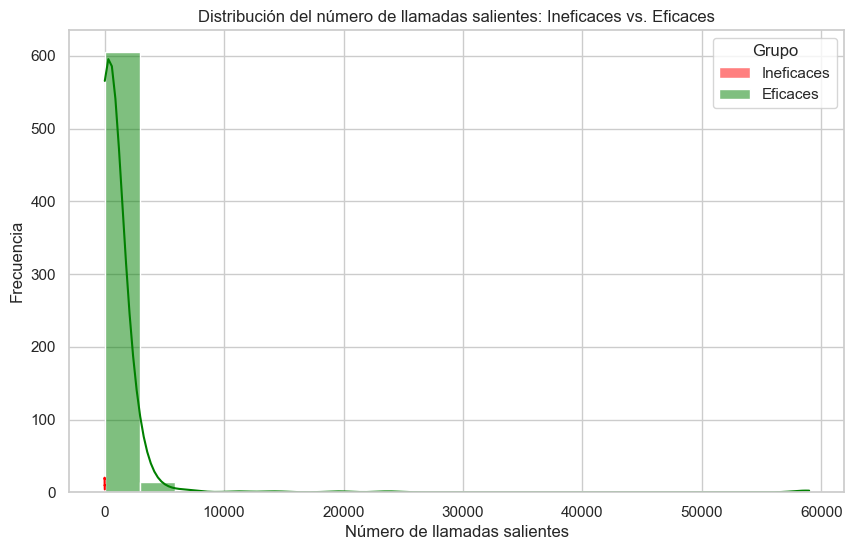

In [15]:
# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Crear el gráfico de distribución
plt.figure(figsize=(10, 6))
sns.histplot(metrics_out[metrics_out['ineffective_out']]['total_llamadas'], 
             color='red', label='Ineficaces', kde=True, bins=20, alpha=0.5)
sns.histplot(metrics_out[~metrics_out['ineffective_out']]['total_llamadas'], 
             color='green', label='Eficaces', kde=True, bins=20, alpha=0.5)

# Añadir título y etiquetas
plt.title('Distribución del número de llamadas salientes: Ineficaces vs. Eficaces')
plt.xlabel('Número de llamadas salientes')
plt.ylabel('Frecuencia')
plt.legend(title='Grupo')
plt.show()

Hay una diferencia significativa en el numero de llamadas salientes entre operadores ineficaces y eficaces.

Esto nos podrias indicar que los operadores ineficaces no estan cumpliendo con las expectaivas en terminos de llamadas salientes. Esto podria indicar que existen algunas causas que se deberian atender como alguna falta de capacitación, motivacion o recursos.

## Predicciones

Objetivo:

    Implementar un modelo de machine learning para predecir que operadores podrian volverse ineficaces en el futuro para las llamadas entrantes.
Definir la tarea:

¿Qué estamos pronosticando y qué tarea de negocio puede resolver esto?   
Estamos pronosticando aquellos operadores que podrian volverse menos ineficaces, lo que nos permitira crear estrategias para mejorar el rendimiento de los mismos.

¿Qué datos tenemos?   
Contamos con los siguintes datos:

* user_id: ID de la cuenta de cliente
* date: fecha en la que se recuperaron las estadísticas
* direction: "dirección" de llamada (out para saliente, in para entrante)
* internal: si la llamada fue interna (entre los operadores de un cliente o clienta)
* operator_id: identificador del operador
* is_missed_call: si fue una llamada perdida
* calls_count: número de llamadas
* call_duration: duración de la llamada (sin incluir el tiempo de espera)
* total_call_duration: duración de la llamada (incluido el tiempo de espera)

¿Quién va a utilizar nuestro modelo y cómo (cómo se integra en los procesos de negocio)?   
El modelo sera una nueva función que brindará a los supervisores información sobre los operadores menos eficaces.

¿Qué resultados esperamos alcanzar?   
Esperamos mejorar el rendimiento de las y los operadores al estar antendiendo a los clientes a traves de las llamadas telefonicas.

¿Cómo se ha resuelto el problema hasta ahora? ¿El método fue exitoso?   
Hasta ahora, el problema no se ha aborado por lo que no hay información suficiente para dar información concreta.

¿Qué efecto podría tener tu modelo en el negocio?   
El modelo puede detectar a aquellos operadores que tengan menor eficiencia en atender llamadas y asi poder crear plan de acción que pueda mejorar su rendimiento.

¿Tienes suficientes recursos (tiempo, personal, finanzas, recursos computacionales)?   
Se espera contar con los recursos necesarios

¿Qué métricas utilizarás para evaluar el desempeño de tu modelo?   
* Accuracy: -Qué modelo tiene el mayor porcentaje de predicciones correctas
* Precision: -Qué modelo tiene la menor proporción de falsos positivos
* Recall: -Qué modelo identifica mejor a los operadores ineficaces
* F1-Score: -Qué modelo tiene el mejor equilibrio entre precisión y recall
* AUC: -Qué modelo tiene la mejor capacidad para distinguir entre clases

¿Existe algún referente en el mercado para la aplicación del aprendizaje automático para tareas similares?   
Por ahora desconocemos si existe algun referente en el mercado.


Lenguaje ML:

El tipo de tarea (aprendizaje supervisado o no supervisado; clasificación, regresión o clustering). *** Aprendizaje supervisado: clasificación.

Características: ¿Qué datos seleccionar como características?    
calls_count, call_duration, total_call_duration, is_missed_call, direction, internal. Datos derivadas: Promedio de llamadas perdidas, tiempo promedio de espera, proporción de llamadas internas vs. externas.

¿Cuál es el tamaño de la muestra?   
Aun no conocemos el dato, se vialuzalizara mas adelante

¿Cuál es el periodo?   
Los datos abarcan desde 2019-08-02 al 2019-11-28, aproximadamente 4 meses de operación.

¿Qué tan buenos son los datos?   
Los datos ya fueron preprocesados para quitar duplicados y datos nulos.

¿Los datos tienen una estructura temporal?    
si, los datos abarcan 4 meses de operación.

Métricas que utilizarás para optimizar y evaluar tu modelo.
Accuracy, Precision, Recall, F1-Score y AUC.

Los algoritmos que vas a utilizar (según los puntos anteriores).
Modelos base como Árboles de Decisión o Regresión Logística para interpretar resultados. Modelos avanzados como Random Forest o Gradient Boosting para mejorar precisión.

In [16]:
metrics_in.describe()

,total_llamadas,llamadas_perdidas,duracion_promedio,tiempo_espera_promedio
count,754.000000,754.000000,754.000000,754.000000
mean,124.405836,0.908488,405.987344,463.600150
std,356.450649,2.405363,757.282822,816.288393
min,1.000000,0.000000,1.000000,7.000000
25%,4.000000,0.000000,74.050000,103.083333
50%,17.000000,0.000000,176.230769,213.566845
75%,78.750000,1.000000,429.663095,476.244286
max,4766.000000,28.000000,12032.696970,12203.545455


In [17]:
print(metrics_in.head())

             total_llamadas  llamadas_perdidas  duracion_promedio  \
operator_id                                                         
879896                   58                  0         267.428571   
879898                  104                  0         111.456140   
880020                    7                  0          42.714286   
880022                    8                  0          64.000000   
880026                   24                  0          88.166667   

             tiempo_espera_promedio  ineffective_in  
operator_id                                          
879896                   294.761905           False  
879898                   140.929825           False  
880020                    50.428571           False  
880022                    78.000000           False  
880026                    96.111111           False  


In [18]:
# para metrics_in
X = metrics_in.drop(columns=['ineffective_in'])  # Features
y = metrics_in['ineffective_in']  # Variable objetivo

# Dividir los datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Entrenar el modelo
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Predecir
y_pred_lr = model_lr.predict(X_test)

# Evaluar
print("Regresión Logística:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))

Regresión Logística:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


Conclusiones:

Las metricas nos estan arrojando datos muy positivos lo cual nos puede indicar que el modelo clasifico correctamente todas las muestras, sin embargo esto puede ser debido a que la misma muestra viene de los calculos previamente realizados para identificar a los operadores.

Para continuar con el modelo tendriamos que solicitar nuevos datos para poder probarlo nuevamente y evaluar que el algoritmo esta realizando correctamente la clasificación.
Otro punto a considerar es que se podria divir los datos antes de calcular a los operadores ineficientes, realizar la clasificación de opeardores con el 80% de los datos diviendolos por periodos de tiempo por la variable 'date' y asi el resto poder usarlos para evaluar el modelo.